Clayton Cohn<br>
DePaul University<br>
19 Apr 2021<br>

#<center> Tagging Concepts in Causal Chains w/ BERT

This code was adapted from Drew Perkins' tutorial via Towards Data Science: 

https://towardsdatascience.com/tagging-genes-and-proteins-with-biobert-c7b04fc6eb4f

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The below cell is for combining the *big* and *little* datasets if we want to do cross-validation. For this notebook, I simply used both the big and little datasets as-is.

In [2]:
'''
This cell used to concatenate big and little partitions
'''

# import pandas as pd

# DATA_PATH = "drive/My Drive/colab/DeepNLP/data/"
# FILE_NAME1 = "EBA1415-SkinCancer-big-reln-repeat-iob2.csv"
# FILE_NAME2 = "EBA1415-SkinCancer-little-reln-repeat-iob2.csv"

# df1 = pd.read_csv(DATA_PATH + FILE_NAME1)
# df2 = pd.read_csv(DATA_PATH + FILE_NAME2)

# print("1:", len(df1))
# print("2:", len(df2))

# df = pd.concat([df1, df2], ignore_index=True)
# print(len(df))

# print(df.head())

# df.to_csv(DATA_PATH + 'EBA1415-SkinCancer-join-reln-repeat-iob2.csv', index=False)

'\nThis cell used to concatenate big and little partitions\n'

In [3]:
DATA_PATH = "drive/My Drive/colab/DeepNLP/data/"
FILE_NAME = "EBA1415-SkinCancer-big-reln-repeat-iob2.csv"

In [4]:
import pandas as pd

df = pd.read_csv(DATA_PATH + FILE_NAME)
df.head(25)

,Sentence #,Word,STag,Tag,Relation,File
0,Sentence 1,This,O,O,O,EBA1415_TFHC_1_SC_ES-05947
1,NaN,essay,O,O,O,NaN
2,NaN,is,O,O,O,NaN
3,NaN,about,O,O,O,NaN
4,NaN,skin,O,O,O,NaN
5,NaN,damage,O,O,O,NaN
6,NaN,",",O,O,O,NaN
7,NaN,latitude,O,O,O,NaN
8,NaN,and,O,O,O,NaN
9,NaN,direct,O,O,O,NaN


This was the raw dataset taken from the wiki. It has a lot of extraneous information that needs to be stripped. Considering that this is a tagging task, all we are concerned with is the sentence numberm, word, and label.

Additionally, the sentence numbers need to be added, as currently only the first word of each sentence has a number.

In [5]:
import numpy as np

df_num = df.copy(deep=True)
df_num.iloc[0]["Sentence #"] = 0
df_num.drop(['File', 'Relation', 'STag'], axis=1, inplace=True)
df_num.columns = ["s_num","word","tag"]
df_num = df_num.fillna(-1)

snum = -1
for idx, row in df_num.iterrows():
  if row["s_num"] == -1: row["s_num"] = snum
  else: 
    snum += 1
    row["s_num"] = snum

df_num.head(25)

,s_num,word,tag
0,0,This,O
1,0,essay,O
2,0,is,O
3,0,about,O
4,0,skin,O
5,0,damage,O
6,0,",",O
7,0,latitude,O
8,0,and,O
9,0,direct,O


Once we have the cleaned and trimmed dataset we can make sure that there are no ```null``` values and also properly format the columns. This is also a good time to do some EDA and take a peek at the data.

In [6]:
print("Any nulls? ", df_num.isnull().values.any())

Any nulls?  False


In [7]:
df_num["s_num"] = df_num["s_num"].astype(str).astype(int)
df_num["word"] = df_num["word"].astype(str)

In [8]:
print("Shape:", df_num.shape)
print(df_num.info())

Shape: (191903, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191903 entries, 0 to 191902
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   s_num   191903 non-null  int64 
 1   word    191903 non-null  object
 2   tag     191903 non-null  object
dtypes: int64(1), object(2)
memory usage: 4.4+ MB
None


In [9]:
print("Unique labels:")
sorted(df_num.tag.unique())

Unique labels:


['B-1',
 'B-11',
 'B-12',
 'B-2',
 'B-3',
 'B-4',
 'B-5',
 'B-50',
 'B-6',
 'B-ANAPHOR',
 'B-BCK',
 'B-EXPLICIT',
 'B-ND',
 'B-OTHER',
 'B-RHETORICAL',
 'I-1',
 'I-11',
 'I-12',
 'I-2',
 'I-3',
 'I-4',
 'I-5',
 'I-50',
 'I-6',
 'I-ANAPHOR',
 'I-BCK',
 'I-EXPLICIT',
 'I-ND',
 'I-OTHER',
 'I-RHETORICAL',
 'O']

There are a bunch of labels that do not correlate to actual concepts in our causal model, so we need to transform those into "O" tags. In this notebook we are only concerned with tagging the actual concepts found in the causal model.  

In [10]:
# Can also add  "B-EXPLICIT", "I-EXPLICIT"

invalids = {"B-ANAPHOR", "B-BCK", "B-CHANGE-FACTOR", "B-ND", "B-OTHER", "B-RHETORICAL", "B-EXPLICIT", "I-EXPLICIT",
            "I-ANAPHOR", "I-CHANGE-FACTOR", "I-ND", "I-OTHER", "I-RHETORICAL", "I-BCK", "B-BCK"}

In [11]:
df_num["tag"] = df_num.apply(lambda x: "O" if x["tag"] in invalids else x["tag"], axis=1)

Additionally, for this notebook, we need to remove the "B" and "I" prefixes and focus just on the concpets themselves.

In [12]:
df_num["tag"] = df_num.apply(lambda x: x["tag"][2:] if x["tag"][:2] in ["B-", "I-"] else x["tag"], axis=1)

Below are the label counts for all of the concepts (and the "O" label).

In [13]:
print(df_num.tag.value_counts())

O     139582
50     13433
1       7345
2       7253
6       7011
5       5796
3       5397
4       3929
12      1212
11       945
Name: tag, dtype: int64


In [14]:
print(df_num.s_num.value_counts()[:10])

2359    123
2361    123
2360    123
7635     91
9331     83
4135     73
6138     71
6137     71
2018     71
6139     71
Name: s_num, dtype: int64


The ```SentenceGetter``` class extracts the sentences from the DataFrame.

In [15]:
class SentenceGetter(object):
  def __init__(self, data):
      self.n_sent = 1
      self.data = data
      self.empty = False
      agg_func = lambda s: [(w, l) for w, l in zip(s["word"].values.tolist(), s["tag"].values.tolist())]
      self.grouped = self.data.groupby("s_num").apply(agg_func)
      self.sentences = [s for s in self.grouped]

  def get_next(self):
      try:
          s = self.grouped["Sentence: {}".format(self.n_sent)]
          self.n_sent += 1
          return s
      except:
          return None

In [16]:
getter = SentenceGetter(df_num)

In [17]:
sents = [[word[0] for word in sentence] for sentence in getter.sentences]
sents[1]

['The',
 'skin',
 'damage',
 'is',
 'on',
 'our',
 'bodies',
 'that',
 'have',
 'numerous',
 'skin',
 'disorders',
 ',',
 'conditions',
 ',',
 'and',
 'diseases',
 '.']

In [18]:
labels = [[s[1] for s in sentence] for sentence in getter.sentences]
print(labels[1])

['O', '4', '4', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


We create a set of all tag values, i.e. concepts. We also add ```PAD``` as a value, as it will be used by BERT as the token for sequence padding.

The ```tag2idx``` dictionary assigns each tag a numerical value, as we are required by BERT to represent labels via integers.

In [19]:
tag_values = list(set(df_num["tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}
tag2idx

{'1': 5,
 '11': 4,
 '12': 2,
 '2': 6,
 '3': 8,
 '4': 3,
 '5': 1,
 '50': 0,
 '6': 7,
 'O': 9,
 'PAD': 10}

In [20]:
!pip install transformers
!pip install torch

     |████████████████████████████████| 2.5MB 14.6MB/s 
     |████████████████████████████████| 901kB 66.2MB/s 
     |████████████████████████████████| 3.3MB 52.9MB/s 


In [21]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

torch.__version__

'1.9.0+cu102'

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

The next step is tokenize the sentences, get their input IDs from BERT, and tensorize them for training.

In [23]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

In [24]:
def tokenize_with_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)
        tokenized_sentence.extend(tokenized_word)
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [25]:
tokenized_texts_and_labels = [tokenize_with_labels(sent, labs) for sent, labs in zip(sents, labels)]

In [26]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

The ```MAX_LEN``` hyperparameter was set to the maximum length instance.

In [27]:
MAX_LEN = max(map(len, tokenized_texts))
BATCH_SIZE = 32
print("MAX_LEN:",MAX_LEN)

MAX_LEN: 139


In [28]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [29]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [30]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [31]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [32]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [33]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=BATCH_SIZE)

In [34]:
import transformers
from transformers import BertForTokenClassification, AdamW

transformers.__version__

'4.8.1'

Create our instance of the PyTorch pretrained BERT model for set up for token classification. 

We will also make sure it runs on our GPU.

In [35]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [36]:
model.cuda();

Set parameters for fine-tuning, then train the model.

In [37]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

In [38]:
from transformers import get_linear_schedule_with_warmup

EPOCHS = 3
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * EPOCHS

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [39]:
!pip install seqeval
from seqeval.metrics import f1_score, accuracy_score

     |████████████████████████████████| 51kB 6.0MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp37-none-any.whl size=16184 sha256=221f4ad3a9f745c9eb07b9158c0e5a11db66613a02b8aae64232539434223fa8
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval


In [40]:
from tqdm import tqdm, trange

## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(EPOCHS, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(valid_tags, pred_tags)))
    print()

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Average train loss: 0.3437782838734376


Epoch:  33%|███▎      | 1/3 [02:05<04:10, 125.23s/it]

Validation loss: 0.20521183142607863
Validation Accuracy: 0.9337253803789788

Average train loss: 0.15789833479274104


Epoch:  67%|██████▋   | 2/3 [04:10<02:05, 125.22s/it]

Validation loss: 0.17416169728632225
Validation Accuracy: 0.9432465229160832

Average train loss: 0.11564001533811892


Epoch: 100%|██████████| 3/3 [06:15<00:00, 125.18s/it]

Validation loss: 0.16585653804411943
Validation Accuracy: 0.9493139176701204



See where the training loss meets the validation loss, and examine the accuracy score, classification report, and confusion matrix of the validation instances.

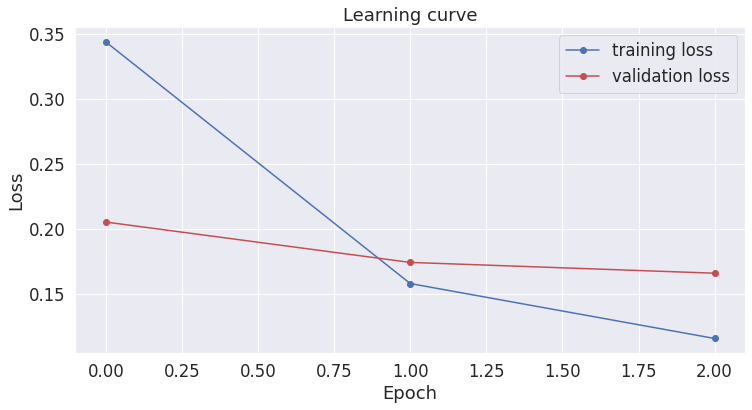

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [42]:
from sklearn.metrics import classification_report
print(classification_report(valid_tags, pred_tags))

              precision    recall  f1-score   support

           1       0.90      0.92      0.91       923
          11       0.94      0.99      0.97       183
          12       0.82      0.84      0.83       157
           2       0.86      0.90      0.88       722
           3       0.94      0.92      0.93       758
           4       0.90      0.86      0.88       423
           5       0.90      0.94      0.92       880
          50       0.92      0.91      0.92      1405
           6       0.87      0.92      0.90       682
           O       0.97      0.96      0.97     15293

    accuracy                           0.95     21426
   macro avg       0.90      0.92      0.91     21426
weighted avg       0.95      0.95      0.95     21426



In [43]:
from sklearn.metrics import confusion_matrix
np.set_printoptions(threshold=50)
print(confusion_matrix(valid_tags, pred_tags))

[[  848     0     0 ...     1     0    55]
 [    0   182     0 ...     0     0     1]
 [    0     0   132 ...     0     0    25]
 ...
 [    0     0     0 ...  1284     0   121]
 [    0     0     0 ...     0   626    52]
 [   87    12    28 ...   103    88 14727]]


Now it's time to evaluate the test data. Like the training dataset, this partition also needs to be cleaned and stripped.


In [44]:
FILE_NAME = "EBA1415-SkinCancer-little-reln-repeat-iob2.csv"

In [45]:
df = pd.read_csv(DATA_PATH + FILE_NAME)
df.head(25)

,Sentence #,Word,STag,Tag,Relation,File
0,Sentence 1,The,O,O,O,EBA1415_TFHC_4_SC_ES-05825
1,NaN,lead,O,O,O,NaN
2,NaN,to,O,O,O,NaN
3,NaN,skin,O,O,O,NaN
4,NaN,cancer,O,O,O,NaN
5,NaN,differ,O,O,O,NaN
6,NaN,on,O,O,O,NaN
7,NaN,a,O,O,O,NaN
8,NaN,few,O,O,O,NaN
9,NaN,things,O,O,O,NaN


In [46]:
df_test = df.copy(deep=True)
df_test.iloc[0]["Sentence #"] = 0
df_test.drop(['File', 'Relation', 'STag'], axis=1, inplace=True)
df_test.columns = ["s_num","word","tag"]
df_test = df_test.fillna(-1)

snum = -1
for idx, row in df_test.iterrows():
  if row["s_num"] == -1: row["s_num"] = snum
  else: 
    snum += 1
    row["s_num"] = snum

df_test.head(25)

,s_num,word,tag
0,0,The,O
1,0,lead,O
2,0,to,O
3,0,skin,O
4,0,cancer,O
5,0,differ,O
6,0,on,O
7,0,a,O
8,0,few,O
9,0,things,O


In [47]:
print("Any nulls? ", df_test.isnull().values.any())

Any nulls?  False


In [48]:
df_test["s_num"] = df_test["s_num"].astype(str).astype(int)

In [49]:
print("Shape:", df_test.shape)
print(df_test.info())

Shape: (48733, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48733 entries, 0 to 48732
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   s_num   48733 non-null  int64 
 1   word    48733 non-null  object
 2   tag     48733 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB
None


In [50]:
print("Unique labels:")
sorted(df_test.tag.unique())

Unique labels:


['B-1',
 'B-11',
 'B-12',
 'B-2',
 'B-3',
 'B-4',
 'B-5',
 'B-50',
 'B-6',
 'B-ANAPHOR',
 'B-EXPLICIT',
 'B-ND',
 'B-RHETORICAL',
 'I-1',
 'I-11',
 'I-12',
 'I-2',
 'I-3',
 'I-4',
 'I-5',
 'I-50',
 'I-6',
 'I-ANAPHOR',
 'I-EXPLICIT',
 'I-ND',
 'I-RHETORICAL',
 'O']

In [51]:
df_test["tag"] = df_test.apply(lambda x: "O" if x["tag"] in invalids else x["tag"], axis=1)

In [52]:
df_test["tag"] = df_test.apply(lambda x: x["tag"][2:] if x["tag"][:2] in ["B-", "I-"] else x["tag"], axis=1)

In [53]:
print(df_test.tag.value_counts()[:10])

O     35401
50     3376
2      2004
1      1838
6      1820
5      1399
3      1378
4      1006
12      319
11      192
Name: tag, dtype: int64


In [54]:
print(df_test.s_num.value_counts()[:10])

1471    82
1470    82
1474    82
1473    82
1475    82
1472    82
2299    77
2297    77
2300    77
2298    77
Name: s_num, dtype: int64


We'll first take a look at a sample sentence to see what the model predicts for the tags versus what the tags actually were.

In [55]:
n = 3
first_sent_word = list(df_test[df_test["s_num"] == n]["word"])
first_sent_label = ["O"] + list(df_test[df_test["s_num"] == n]["tag"])

test_sentence = ""
for val in first_sent_word:
  test_sentence += val + ' '

test_tokenized_sentence = tokenizer.encode(test_sentence)
test_input_ids = torch.tensor([test_tokenized_sentence]).cuda()
with torch.no_grad():
    output = model(test_input_ids)
test_label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)
print(output)
test_tokens = tokenizer.convert_ids_to_tokens(test_input_ids.to('cpu').numpy()[0])

new_tokens, new_labels = [], []
for token, idx in zip(test_tokens, test_label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[idx])
        new_tokens.append(token)
for token, label, old in zip(new_tokens, new_labels, first_sent_label):
    print("{}\t{}\t{}".format(label, token, old))

TokenClassifierOutput(loss=None, logits=tensor([[[-7.3979e-01, -1.9017e-01, -1.0539e+00, -6.5893e-01, -1.1006e+00,
           4.3528e-01,  1.4805e+00, -1.3541e+00,  2.2998e-01,  2.7586e+00,
          -1.2011e+00],
         [-4.3563e-02, -2.6884e-01, -7.2221e-01, -1.7684e-01, -1.1355e+00,
          -1.3931e-01,  2.7228e-01, -7.5400e-01, -3.4786e-01,  2.4521e+00,
          -1.0712e+00],
         [-1.7557e-01, -4.9016e-01, -1.6266e+00, -7.5319e-01, -1.3461e+00,
           5.4033e-01,  9.1835e-01, -1.2669e+00, -4.7818e-01,  5.0687e+00,
          -2.0995e+00],
         [-5.5670e-01, -4.2961e-01, -1.8234e+00, -1.2494e+00, -1.1831e+00,
          -1.0649e-01,  3.2525e+00, -1.7599e+00, -8.1929e-01,  4.7604e+00,
          -2.0411e+00],
         [-1.1433e+00,  7.2934e-02, -1.3984e+00, -1.1488e+00, -1.6357e+00,
          -3.0979e-01,  5.2855e+00, -2.0001e+00, -1.3711e-01,  1.8787e+00,
          -1.8869e+00],
         [ 1.0475e-01, -1.1173e-01, -7.3673e-01, -6.9295e-01, -6.6007e-01,
          -1.16

Now is the actual evaluation of the entire test set, followed by the classification report and confusion matrix.

In [56]:
y_pred = []
y_true = []
y_tokens = []

for i in range(max(df_test["s_num"]+1)):
  first_sent_word = list(df_test[df_test["s_num"] == i]["word"])
  first_sent_label = ["O"] + list(df_test[df_test["s_num"] == i]["tag"]) + ["O"]

  test_sentence = ""
  for val in first_sent_word:
    test_sentence += val + ' '
  # print(test_sentence) 

  test_tokenized_sentence = tokenizer.encode(test_sentence)
  test_input_ids = torch.tensor([test_tokenized_sentence]).cuda()
  with torch.no_grad():
      output = model(test_input_ids)
  test_label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

  test_tokens = tokenizer.convert_ids_to_tokens(test_input_ids.to('cpu').numpy()[0])

  new_tokens, new_labels = [], []
  for token, idx in zip(test_tokens, test_label_indices[0]):
      if token.startswith("##"):
          new_tokens[-1] = new_tokens[-1] + token[2:]
      else:
          new_labels.append(tag_values[idx])
          new_tokens.append(token)
  y_pred += new_labels
  y_true += first_sent_label
  y_tokens += new_tokens
# print(len(y_pred))
# print(len(y_true))

In [57]:
report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           1       0.83      0.81      0.82      1838
          11       0.78      0.82      0.80       192
          12       0.78      0.76      0.77       319
           2       0.85      0.82      0.84      2004
           3       0.82      0.89      0.85      1378
           4       0.81      0.77      0.79      1006
           5       0.86      0.85      0.85      1399
          50       0.77      0.89      0.82      3376
           6       0.91      0.75      0.82      1820
           O       0.95      0.94      0.95     40641

    accuracy                           0.92     53973
   macro avg       0.84      0.83      0.83     53973
weighted avg       0.92      0.92      0.92     53973



In [58]:
print(confusion_matrix(y_true, y_pred))

[[ 1482     0     0 ...     0     0   338]
 [    0   158     0 ...     0     0    34]
 [    0     0   244 ...     2     0    73]
 ...
 [    2     0     0 ...  2994     0   375]
 [    0     0     0 ...     2  1363   421]
 [  295    45    67 ...   889   123 38393]]


In [59]:
# df_report = pd.DataFrame(report).transpose()
# df_report.head()

In [60]:
# df_report.to_csv(DATA_PATH + 'tagging_results_sc.csv')

In [61]:
# word_acc = {}

# for word, true, pred in zip(y_tokens, y_true, y_pred):
#   if word in word_acc:
#     word_acc[word][1] += 1
#     if pred == true: word_acc[word][0] += 1
#   else:
#     word_acc[word] = [1,1] if pred == true else [0,1]
  
# word_acc = {k: [v[0]/v[1], v[1]] for k, v in word_acc.items()}
# word_acc["the"]

In [62]:
# word_arr = sorted(word_acc.items(), key=lambda item: item[1][1])
# word_arr[-20:]

In [63]:
FILE_NAME = "EBA1415-SkinCancer-little-sentences.tsv"

In [64]:
df_rels_test = pd.read_csv(DATA_PATH + FILE_NAME, header=0, names=['file', 'relation', 's_num', 'sentence'], sep="\t")
df_rels_test.head(25)

,file,relation,s_num,sentence
0,EBA1415_TFHC_4_SC_ES-05825,O,1.0,The lead to skin cancer differ on a few things...
1,EBA1415_TFHC_4_SC_ES-05825,R-1-50,2.1,Some skin cancer can be caused by the location...
2,EBA1415_TFHC_4_SC_ES-05825,R-1-2,2.2,Some skin cancer can be caused by the location...
3,EBA1415_TFHC_4_SC_ES-05825,R-1-2,3.1,The reason the sun matters is because of the d...
4,EBA1415_TFHC_4_SC_ES-05825,R-2-3,3.2,The reason the sun matters is because of the d...
5,EBA1415_TFHC_4_SC_ES-05825,R-5-50,4.0,Another cause of skin cancer is sunbrun.
6,EBA1415_TFHC_4_SC_ES-05825,R-5-50,5.0,While sunbrun isn't much to worie about you ca...
7,EBA1415_TFHC_4_SC_ES-05825,O,6.0,Didn't finished
8,EBA1415_WSAL_2_SC_ES-05359,R-2-50,7.1,There are two main reasons why people can deve...
9,EBA1415_WSAL_2_SC_ES-05359,R-3-50,7.2,There are two main reasons why people can deve...


In [65]:
df_rels_test.drop(["file", "s_num"], inplace=True, axis=1)
df_rels_test.head(25)

,relation,sentence
0,O,The lead to skin cancer differ on a few things...
1,R-1-50,Some skin cancer can be caused by the location...
2,R-1-2,Some skin cancer can be caused by the location...
3,R-1-2,The reason the sun matters is because of the d...
4,R-2-3,The reason the sun matters is because of the d...
5,R-5-50,Another cause of skin cancer is sunbrun.
6,R-5-50,While sunbrun isn't much to worie about you ca...
7,O,Didn't finished
8,R-2-50,There are two main reasons why people can deve...
9,R-3-50,There are two main reasons why people can deve...


Additionally, there is an ```R-4-RHETORICAL``` relation that must be stripped from this test set because it does not consist of two concept codes.

In [66]:
df_rels_test.drop(df_rels_test.loc[df_rels_test['relation']=='R-4-RHETORICAL'].index, inplace=True)

Extract words as single rows with sentence numbers to feed into tagger.

In [67]:
import re

n = 0
sents = []
rels = {}
for idx, row in df_rels_test.iterrows():
  sent = re.findall(r"[\w]+|[^\s\w]", row["sentence"])
  for word in sent:
    sents.append([n, word])
  rels[n] = row["relation"]
  n += 1
sents = np.array(sents)

Convert array to dataframe.

In [68]:
df_test_words = pd.DataFrame(sents, columns = ['s_num','word'])
df_test_words["s_num"] = pd.to_numeric(df_test_words["s_num"])
df_test_words.head(100)

,s_num,word
0,0,The
1,0,lead
2,0,to
3,0,skin
4,0,cancer
...,...,...
95,2,you
96,2,are
97,2,and
98,2,how


Test it on the first sentence.

In [69]:
n = 0
first_sent_word = list(df_test_words[df_test_words["s_num"] == n]["word"])

test_sentence = ""
for val in first_sent_word:
  test_sentence += val + ' '
# print(test_sentence) 

test_tokenized_sentence = tokenizer.encode(test_sentence)
test_input_ids = torch.tensor([test_tokenized_sentence]).cuda()
with torch.no_grad():
    output = model(test_input_ids)
test_label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

test_tokens = tokenizer.convert_ids_to_tokens(test_input_ids.to('cpu').numpy()[0])

new_tokens, new_labels = [], []
for token, idx in zip(test_tokens, test_label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[idx])
        new_tokens.append(token)
pred = "R-"
concepts = list(dict.fromkeys(new_labels))
if "O" in concepts: concepts.remove("O")

rel = []
for i in range(1,len(concepts)):
  rel.append(["R-" + str(concepts[i-1]) + "-" + str(concepts[i])])
if not rel: rel = ["O"]
rel

['O']

Now let's generate all of our predictions!

In [70]:
ordered = {"1" : 0, "2" : 1, "3" : 2, "4" : 3, "5" : 4, "11" : 5, "12" : 6, "6" : 7, "50" : 8}
ordered_inv = dict([(value, key) for key, value in ordered.items()])

preds = {}

for i in range(max(df_test_words["s_num"]+1)):
  first_sent_word = list(df_test_words[df_test_words["s_num"] == i]["word"])

  test_sentence = ""
  for val in first_sent_word:
    test_sentence += val + ' '
  # print(test_sentence) 

  test_tokenized_sentence = tokenizer.encode(test_sentence)
  test_input_ids = torch.tensor([test_tokenized_sentence]).cuda()
  with torch.no_grad():
      output = model(test_input_ids)
  test_label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

  test_tokens = tokenizer.convert_ids_to_tokens(test_input_ids.to('cpu').numpy()[0])

  new_tokens, new_labels = [], []
  for token, idx in zip(test_tokens, test_label_indices[0]):
      if token.startswith("##"):
          new_tokens[-1] = new_tokens[-1] + token[2:]
      else:
          new_labels.append(tag_values[idx])
          new_tokens.append(token)
  pred = "R-"

  concepts = list(dict.fromkeys(new_labels))
  if "O" in concepts: concepts.remove("O")
  temp = [ordered[r] for r in concepts]
  temp.sort()
  temp = [ordered_inv[n] for n in temp]
  concepts = temp   

  rel = []
  for j in range(len(concepts)-1):
    for k in range(j+1, len(concepts)):
      rel.append("R-" + str(concepts[j]) + "-" + str(concepts[k]))
  if not rel: rel = ["O"]
  preds[i] = rel

Need to adjust the preds to correspond to a single relation.

In [71]:
for k, v in preds.items():
  if rels[k] == "O": preds[k] = preds[k][0]
  elif rels[k] in preds[k]: preds[k] = rels[k]
  else: preds[k] = rels[0]

print(preds)
print(rels)

{0: 'O', 1: 'R-1-50', 2: 'R-1-2', 3: 'R-1-2', 4: 'R-2-3', 5: 'R-5-50', 6: 'R-5-50', 7: 'O', 8: 'O', 9: 'O', 10: 'O', 11: 'O', 12: 'O', 13: 'R-1-2', 14: 'R-1-50', 15: 'R-3-50', 16: 'R-3-4', 17: 'R-3-4', 18: 'R-2-4', 19: 'R-5-50', 20: 'R-6-50', 21: 'R-4-6', 22: 'R-6-50', 23: 'O', 24: 'O', 25: 'O', 26: 'O', 27: 'O', 28: 'O', 29: 'R-1-2', 30: 'O', 31: 'O', 32: 'O', 33: 'O', 34: 'R-3-50', 35: 'R-3-6', 36: 'O', 37: 'O', 38: 'O', 39: 'O', 40: 'O', 41: 'R-5-6', 42: 'R-6-50', 43: 'O', 44: 'R-5-6', 45: 'R-1-2', 46: 'R-1-2', 47: 'O', 48: 'R-1-50', 49: 'R-5-50', 50: 'O', 51: 'O', 52: 'R-5-6', 53: 'R-6-50', 54: 'R-5-50', 55: 'O', 56: 'O', 57: 'O', 58: 'O', 59: 'O', 60: 'R-1-2', 61: 'O', 62: 'O', 63: 'O', 64: 'O', 65: 'O', 66: 'R-2-50', 67: 'R-2-50', 68: 'R-1-2', 69: 'O', 70: 'R-1-2', 71: 'R-1-50', 72: 'O', 73: 'R-2-6', 74: 'R-11-12', 75: 'O', 76: 'O', 77: 'R-11-12', 78: 'O', 79: 'R-11-12', 80: 'O', 81: 'O', 82: 'R-5-50', 83: 'O', 84: 'O', 85: 'O', 86: 'O', 87: 'R-1-2', 88: 'R-2-50', 89: 'R-1-50', 9

Convert dictionaries to arrays.

In [72]:
y_true = []
y_pred = []
for k, v in preds.items():
  y_true.append(rels[k])
  y_pred.append(preds[k])

Get the stats!

In [73]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           O       0.75      0.91      0.82      1204
      R-1-12       0.00      0.00      0.00         0
       R-1-2       0.80      0.89      0.84       133
       R-1-3       0.93      0.78      0.85        18
       R-1-4       0.50      1.00      0.67         1
       R-1-5       1.00      1.00      1.00         6
      R-1-50       0.87      0.63      0.73       112
     R-11-12       1.00      0.69      0.82        52
      R-11-3       0.00      0.00      0.00         2
     R-11-50       1.00      0.57      0.73        14
      R-12-2       0.00      0.00      0.00         3
      R-12-3       0.00      0.00      0.00        66
     R-12-50       0.40      0.57      0.47         7
      R-2-11       0.00      0.00      0.00         0
      R-2-12       0.00      0.00      0.00         0
       R-2-3       0.93      0.95      0.94        58
       R-2-4       1.00      0.74      0.85        19
       R-2-5       0.79    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [80]:
report = pd.DataFrame.from_dict(classification_report(y_true, y_pred, output_dict=True)).transpose()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [81]:
report.to_csv(DATA_PATH + 'tagging_results_with_relations_sc.csv')